# Quan Zhou
## This is Python3 Code for GIS 321 Exam1

In [2]:
"""""
This five functions used in this solutions.
--------------------------
read_csv:
-->import: csv path(string)
-->output: list of csv content(list)

get_attribute:
-->import: list of csv content(list), attribute name(string)
-->output: list of attribute values(list)

to_float:
-->import: list of attribute values(list of string)
-->output: list of attribute values(list of float)

haversine_distance:
-->import: two points(list)
-->output: haversine distance of two points(float)

min_D:
-->import: point(list), list of points(list)
-->output: index of nearst point in list(int), distance(float), nearest point(element of points list)
--------------------------
"""""
import math
import csv

def read_csv(file_name):
    newlines = []
    with open(file_name, 'r') as f:
        reader = csv.reader(f)
        for line in reader:
            newlines.append(line)
    return newlines

def get_attribute(data, attribute_name):
    header = data[0]
    idx = header.index(attribute_name)
    return [record[idx] for record in data[1:]]

def to_float(attribute_list):
    return list(map(float, attribute_list))

def haversine_distance(point1, point2):
    # Unit: Km
    Lat1, Lon1 = point1
    Lat2, Lon2 = point2
    lat1 = math.radians(Lat1)
    lat2 = math.radians(Lat2)
    lon1 = math.radians(Lon1)
    lon2 = math.radians(Lon2)
    
    dlat = lat1 - lat2
    dlon = lon1 - lon2
    p1 = (math.sin(dlat/2))**2
    p2 = math.cos(lat1)*math.cos(lat2)
    p3 = (math.sin(dlon/2))**2
    r = 12800*math.asin(math.sqrt(p1+p2*p3))
    return r

def min_D (point,aports):
    index = 0
    min_dis = float('inf')
    for i, airport in enumerate(aports):
        if point == airport or airport[1]==9999:
            continue
        if haversine_distance([point[1],point[2]], [airport[1],airport[2]])<min_dis:
            min_dis = haversine_distance([point[1],point[2]], [airport[1],airport[2]])
            index = i
    return [index,min_dis,aports[index]]

## Q1:
### To find the route with the shortest possible distance that visits each intermediate city ( Phoenix (KPHX), Johannesburg (FAJS), London (EGLL), New York (KJFK), Sydney (YSSY)) exactly once and returns to the origin city.

In [3]:
# read latitude, longtitude and name of aiports data from data.csv file
data = read_csv("data.csv")
lat = to_float(get_attribute(data,'latitude'))
lon = to_float(get_attribute(data,'longitude'))
nms = get_attribute(data,'iaco')
points = list(zip(nms,lat,lon))

# select the required aiports and store them in a list
aports = []
for i, airport in enumerate(points):
    if airport[0] == 'KPHX' or airport[0] =='FAJS' or airport[0] =='EGLL' or airport[0] =='KJFK'or airport[0] =='YSSY':
        aports.append(points[i])

In [4]:
# find the shortest distances that visits each intermediate city
trip = [] # for each trip [[#,*],[#, distance, next_stop],[#, distance, next_stop]...]
trips = []  # for all possible trips with [trip1, trip2, trip3, trip4, trip5]
for i,start in enumerate(aports): # where to start
    ap = aports[:]
    next1 = min_D (start,ap)
    ap[i] = ('null',9999,9999)
    next2 = min_D (aports[next1[0]],ap)
    ap[next1[0]] = ('null',9999,9999)
    next3 = min_D (aports[next2[0]],ap)
    ap[next2[0]] = ('null',9999,9999)
    next4 = min_D (aports[next3[0]],ap)
    ap[next3[0]] = ('null',9999,9999)
    next5 = [i,haversine_distance([ap[0][1],ap[0][2]], [aports[0][1],aports[0][2]])]
    trip = [[i,'*'], next1, next2, next3, next4, next5]# each point is the nearest point to last point, the last point is start point
    trips.append(trip)

In [5]:
# find the shorted trip in all five trips wiht different start point
min_Dis = float('inf')
index = 0 # the index of each airport in the list
sequence = [] # the sequence of airpots in the shortes trip
for i, trip in enumerate(trips):
    one_trip = 0
    for stop in trip[1:]:
        one_trip = one_trip + stop[1]
    if one_trip<min_Dis:
        min_Dis = one_trip
        index = i
for stop in trips[index]:
    sequence.append(aports[stop[0]])        

print("*The shortes trip is %.2f km. The order of airport shows as follow:*\n" %min_Dis)
for i in range(5):
    print(sequence[i])

*The shortes trip is 44775.68 km. The order of airport shows as follow:*

('YSSY', -33.946111, 151.177222)
('FAJS', -26.139166, 28.246)
('EGLL', 51.4775, -0.461389)
('KJFK', 40.639751, -73.778925)
('KPHX', 33.434278, -112.011583)


## Q2:
### To provide a list of the countries with borders that intersect the route. For each leg of the route, use 20 equally spaced intermediate points to approximate the leg of the route.

In [6]:
import pyproj
import matplotlib.pyplot as plt
from shapely.geometry import LineString, asShape
import numpy as np
import json
%pylab inline

Populating the interactive namespace from numpy and matplotlib


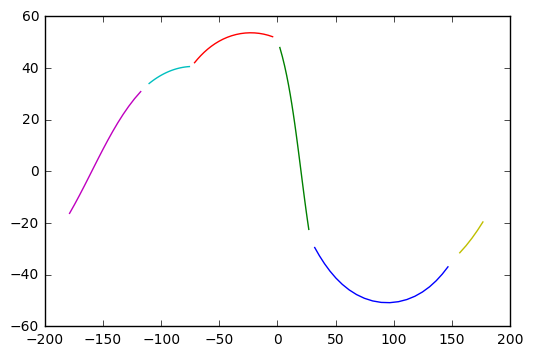

In [10]:
eline = [] # to store each point int the route of trip
g = pyproj.Geod(ellps='WGS84') # to define the projection
for i in range(5):
    # store each lag of route with 20 equally spaced intermediate points
    intermediate = g.npts(sequence[i][2], sequence[i][1], sequence[i+1][2], sequence[i+1][1], 20)
    # for the lag across 180E, I devide the lag into:
    intermediate1 = [] # lag in the eastern hemisphere
    intermediate2 = [] # lag in the western hemisphere
    if abs(sequence[i][2]-sequence[i+1][2])>180:
        for i,inter in enumerate(intermediate):
            if (abs(intermediate[i-1][0]-intermediate[i][0])>180 and i>0):
                index = i
        for i in intermediate[:index]:
            intermediate1.append(i)
        eline.extend(intermediate1)
        intermediateA = np.array(intermediate1)
        plt.plot(intermediateA[:,0],intermediateA[:,1])
        for i in intermediate[index:]:
            intermediate2.append(i)
        eline.extend(intermediate2)
        intermediate = np.array(intermediate2)
        plt.plot(intermediate[:,0],intermediate[:,1])
    else: # for other lags without crossing 180E 
        intermediate = np.array(intermediate)
        eline.extend(intermediate)
        plt.plot(intermediate[:,0],intermediate[:,1])
        plt.xlim(-200,200)
        
# read contries polygon form geojson file
f = "countries.geojson"
with open(f, 'r') as infile:
    gj = json.load(infile)

sf = [] # to store each shape file as a list of point
for i,feature in enumerate(gj['features']):
    sf.append( asShape(feature['geometry']))
eLine = LineString(eline)

ef = [] # to store each country crossed by route
index = [] # to store the index of each country crossed by route
for i,f in enumerate(sf):
    if f.crosses(eLine):
        ef.append(f)
        index.append(i)

In [12]:
countries = [] # to store the countries' name crossed by the route 
for i in index:
    countries.append(gj['features'][i]['properties']['ADMIN'])
print("*The name of the countries with borders that intersect the route shows as follow:*\n")
for i in countries:
    print (i)
print(len(countries))

*The name of the countries with borders that intersect the route shows as follow:*

Angola
Australia
Bolivia
Brazil
Botswana
Central African Republic
Canada
Democratic Republic of the Congo
Algeria
France
United Kingdom
Ireland
Libya
Madagascar
Mexico
Mozambique
Namibia
Niger
Peru
French Polynesia
Chad
Tunisia
United States of America
Vanuatu
South Africa
Zambia
Zimbabwe
27
